In [1]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import collections 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns

from kde_spikephase import kde_spikephase_estimator_forarray
from mdl_eval_tools import bayes,kl,logloss
from pprint import pprint
from rayleigh_pr import rayleigh_pr
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

sns.set(font_scale=2,style='whitegrid')

pd.options.display.max_colwidth = 100

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### functions to select the relevant probability and compute the log loss deltas
The file structure for the approach and odor sampling epochs is different, so you'll have to uncomment certain lines. 

In [2]:
def grab_probs_and_data(datapath,rh_folders,cell_id,fold,filename_probs,filename_data):
    """
    datapath: 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'
    rh_folders: os.listdir(datapath)
    cell_id: 'LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c'
    fold: scalar
    filename_probs: 'probs_models_test.csv'
    filename_data: 'test_data.csv'
    """
    
    test = []
    ptest=[]
    
    for f in rh_folders:
    
        rh_path = os.path.join(datapath, f)
        rh_path_to_cell = rh_path + '/folds/' + str(fold) + '/single_neuron/' + cell_id #uncomment for odor
#         rh_path_to_cell = rh_path + '/folds/' + str(fold) + '/' + cell_id #uncomment for approach
        
        rhythm = f.split('phase')[0]

        #just read a few columns from the test df
#         testtmp = pd.read_csv(os.path.join(rh_path_to_cell, filename_data), usecols = ['spikes','trial_labels'])


        testtmp = pd.read_csv(os.path.join(rh_path_to_cell, filename_data), usecols = ['spikes','phase','trial_labels'])
        testtmp['rhythm'] = np.repeat(rhythm, testtmp.shape[0])
        testtmp['cell_id'] = np.repeat(cell_id, testtmp.shape[0])

        test.append(testtmp)

        ptesttmp = pd.read_csv(os.path.join(rh_path_to_cell, filename_probs))
        ptesttmp['rhythm'] = np.repeat(rhythm, ptesttmp.shape[0])
        ptesttmp['cell_id'] = np.repeat(cell_id, ptesttmp.shape[0])
        ptesttmp['trial_labels'] = testtmp['trial_labels'].values

        ptest.append(ptesttmp)
    
    ptest = pd.concat(ptest)
    test = pd.concat(test)
    
    return ptest, test

In [3]:
from process_lfps import create_data_segments

def compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset):
    """
    ptest: df obtained from function grab_probs_and_data.py
    test: df obtained from function grab_probs_and_data.py
    window_size: scalar [ms], e.g. 50ms windows
    window_slide: scalar [ms], e.g. same size as window for no overlap at all
    model_subset: list of model names, e.g. ['cshort', 'phase']
    rhythm_subset: list of rhythm names you want to grab models for, ['theta','beta','lowgamma', 'highgamma']
    """
    
    trial_labels = list(set(test['trial_labels'].to_list()))
    rhythm_labels = list(set(test['rhythm'].to_list()))
    
    # break the trials into windows
    gather_dfs = []
    for rhythm in rhythm_labels:

        for trial in trial_labels:

            subtest = test[(test['trial_labels']==trial) & (test['rhythm'] == rhythm)]
            subptest = ptest[(ptest['trial_labels']==trial) & (ptest['rhythm'] == rhythm)]

            tmp = create_data_segments(subtest['spikes'].values,window_size,window_slide,['spikes','win_labels'])
            tmp['trial_labels'] = np.repeat(trial,tmp.shape[0])
            tmp['rhythm'] = np.repeat(rhythm,tmp.shape[0])

            gather_dfs.append(tmp)

    windowed_data = pd.concat(gather_dfs)   
    
    #since the windowed data drops some ms, make sure to drop the corresponding ms for each trial in test/ptest dfs
    len_trial = test[(test['trial_labels'] == trial_labels[0]) & (test['rhythm'] == rhythm)].shape[0]
    windowed_len_trial = windowed_data[(windowed_data['trial_labels'] == trial_labels[0]) & (windowed_data['rhythm'] == rhythm)].shape[0]

    rows_to_drop = len_trial - windowed_len_trial
    gather_test = []
    gather_ptest = []
    for rhythm in rhythm_labels:

        for trial in trial_labels:

            subtest = test[(test['trial_labels']==trial) & (test['rhythm'] == rhythm)]
            subptest = ptest[(ptest['trial_labels']==trial) & (ptest['rhythm'] == rhythm)]
            subwin = windowed_data[(windowed_data['trial_labels'] == trial) & (windowed_data['rhythm'] == rhythm)]

            n = subtest.drop(index=subtest.tail(rows_to_drop).index)
            m = subptest.drop(index=subptest.tail(rows_to_drop).index)

            n['window_labels'] = subwin['win_labels'].values
            m['window_labels'] = subwin['win_labels'].values

            gather_test.append(n)
            gather_ptest.append(m)

    shaved_test = pd.concat(gather_test)
    shaved_ptest = pd.concat(gather_ptest)  

    window_labels = list(set(shaved_test['window_labels'].to_list()))
    
    # now compute the log loss delta between models per window
    gather_ptest = []
    gather_test = []
    for rhythm in rhythm_subset: 
        for trial in trial_labels: 
            subptest = shaved_ptest[(shaved_ptest['rhythm'] == rhythm) & (shaved_ptest['trial_labels'] == trial)]
            subtest = shaved_test[(shaved_test['rhythm'] == rhythm) & (shaved_test['trial_labels'] == trial)]

            subptest['spikes'] = subtest['spikes']
            subptest['phases'] = subtest['phase']

            for model in model_subset: 


                _, _, subptest['logloss_'+model] = logloss(subptest['p_'+model].values, subtest['spikes'].values)


                gather_ptest.append(subptest)

    ll_ptest = pd.concat(gather_ptest)

    
    return ll_ptest

## Run the cell below to create a df of log loss deltas for the desired phase-based models
This cell takes a while, so you can skip it if you've already run it previously and have saved the output

In [ ]:
# cell_path = '/Volumes/Sula/PhaseModelsOverTime/data/python_spkphaseOdorsamp_multirhythm/'
# cell_labels = os.listdir(cell_path)
# cell_labels = [c for c in cell_labels if not c.startswith('.')]

# cell_path = 'RESULTS/PHASE_HIST_MODELS_highvapproach_all_realcells/starintlogoddsCompleteSinglePredMdls177/theta_250ms/folds/0/'
# cell_labels = ['LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat',
#                'LH16_D29_ctxtsig_odorblock1_TETSPK53c.mat',
#                'LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a.mat'
#               ]

cell_path = 'RESULTS/PHASE_HIST_MODELS_highvapproach_correctedPos_all_realcells/starintlogoddsCompleteSinglePredMdls/theta_250ms/folds/0/'
cell_labels = os.listdir(cell_path)
cell_labels = [c for c in cell_labels if not c.startswith('.')]

# datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'
# datapath = 'RESULTS/PHASE_HIST_MODELS_highvapproach_all_realcells/starintlogoddsCompleteSinglePredMdls177/'
datapath = 'RESULTS/PHASE_HIST_MODELS_highvapproach_correctedPos_all_realcells/starintlogoddsCompleteSinglePredMdls/'

rh_folders = os.listdir(datapath)

# cell_labels = ['LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c',
#                'LH9_10_10_13_D10_theta_correct_odorblock2TETSPK13a',
#                'LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a'
#               ]

# cell_labels = ['LH16_07_09_14_D09_theta_correct_odorblock1TETSPK37c']

# cell_labels = list(cell_labels)

window_size = 50
window_slide = 50
model_subset = ['cshort','hshort']
# rhythm_subset = ['theta','lowgamma']
rhythm_subset = ['theta_250ms','lowgamma_250ms']

loss_delta_tmp = []

for cell_id in tqdm(cell_labels):
    
    for fold in range(20): 


        ptest, test = grab_probs_and_data(datapath,rh_folders,cell_id,fold,'probs_models_test.csv','test_data.csv')

        
        ll_ptest = compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset)

        #take the mean here because: the model probabilities are so close to zero, and spiking is so rare, that most 
        #of the time the losses will be really really small, and only rarely will they be close to ~4 or ~5. Taking 
        #the mean of this very skewed (bimodal) distribution ensures that you're taking the large losses into account
        #and will thus be able to distinguish between subtle differences in model performance.
        grouped_ptest = ll_ptest.groupby(['rhythm','trial_labels','window_labels']).mean()[['logloss_cshort','logloss_hshort']].reset_index()
        grouped_ptest = ll_ptest.groupby(['rhythm','window_labels']).mean()[['logloss_cshort','logloss_hshort']].reset_index()


#         subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta']
#         sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma']
        
        subthetaloss = grouped_ptest[grouped_ptest['rhythm'] == 'theta_250ms']
        sublowgammaloss = grouped_ptest[grouped_ptest['rhythm'] == 'lowgamma_250ms']
        
        delta_theta_lowgamma = subthetaloss['logloss_cshort'].values - sublowgammaloss['logloss_cshort'].values
        delta_theta_hshort = subthetaloss['logloss_cshort'].values - subthetaloss['logloss_hshort'].values
        delta_lowgamma_hshort = sublowgammaloss['logloss_cshort'].values - sublowgammaloss['logloss_hshort'].values

        tmp = {'cell_id': np.repeat(cell_id,subthetaloss.shape[0]),
               'delta_logloss_theta_minus_lowgamma': delta_theta_lowgamma,
               'delta_logloss_theta_minus_hshort': delta_theta_hshort,
               'delta_logloss_lowgamma_minus_hshort': delta_lowgamma_hshort,
               'window_labels': sublowgammaloss['window_labels'].to_list(),
               'fold': np.repeat(fold,subthetaloss.shape[0])}

        loss_delta_tmp.append(pd.DataFrame(tmp))
    
loss_delta_df = pd.concat(loss_delta_tmp)
    

### ordering the population
start here to generate the (ordered) heatmaps of cells (rows) by time (columns) with log loss deltas as the color scale.

In [4]:
df_odor = pd.read_csv('loss_delta_theta_lowgamma_odor_allcells.csv')
# df_approach = pd.read_csv('loss_delta_theta_lowgamma_approach_allcells.csv')
df_approach = pd.read_csv('df_approach_correctedPos.csv')

In [5]:
df_odor.shape,df_approach.shape

((67000, 10), (67000, 7))

Find the core identities so you can map the correct cells across dfs

In [6]:
cell_labels = list(set(df_approach['cell_id'].to_list()))
unique_ids = []
gather_dfs = []
for cell_id in cell_labels: 
    
    #find rat name
    ratname = cell_id.split('_')[0]
    
    #find session name 
    sessionname = cell_id.split('_')[1]
    
    #find block id
    blockname = cell_id.split('_')[3]
    
    #find unit ids
#     unitname = cell_id.split('_')[-1].split('.mat')[0]
    unitname = cell_id.split('TETSPK')[1].split('.mat')[0]
    
    unique = ratname + '_' + sessionname + '_' + blockname + '_' + unitname
    unique_ids.append(unique)
    
    index = df_approach.loc[df_approach['cell_id']==cell_id]
    index['core_cell_id'] = unique
    
    gather_dfs.append(index)
    
unique_ids = set(unique_ids)  
df_approach_core = pd.concat(gather_dfs)


/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_683/22230630.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['core_cell_id'] = unique


In [7]:
cell_labels = list(set(df_odor['cell_id'].to_list()))
unique_ids = []
gather_dfs = []
for cell_id in cell_labels: 
    
    #find rat name
    ratname = cell_id.split('_')[0]
    
    #find session name 
    sessionname = cell_id.split('_')[4]
    if sessionname[1] == '0':
        sessionname1 = sessionname.split('0')[0]
        sessionname2 = sessionname.split('0')[1]
        sessionname = sessionname1 + sessionname2
    
    #find block id
    tmp_blockname = cell_id.split('TET')[0]
    blockname = tmp_blockname.split('_')[-1]
    #find unit ids
    unitname = cell_id.split('TETSPK')[1]
    
    unique = ratname + '_' + sessionname + '_' + blockname + '_' + unitname
    unique_ids.append(unique)
    
    index = df_odor.loc[df_odor['cell_id']==cell_id]
    index['core_cell_id'] = unique
    
    gather_dfs.append(index)
    
unique_ids = set(unique_ids)  
df_odor_core = pd.concat(gather_dfs)

/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_683/550639591.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['core_cell_id'] = unique


Choose the model comparison you want to order the heatmaps by

In [8]:
delta_to_orderBy = 'delta_logloss_theta_minus_lowgamma'

In [9]:
tmp = df_odor_core.reset_index()
tmp2 = tmp.groupby(['core_cell_id','window_labels']).median()[delta_to_orderBy].reset_index()

In [10]:
tmp2

,core_cell_id,window_labels,delta_logloss_theta_minus_lowgamma
0,LH16_D10_odorblock1_21k,0,-0.003079
1,LH16_D10_odorblock1_21k,1,-0.001255
2,LH16_D10_odorblock1_21k,2,0.003540
3,LH16_D10_odorblock1_21k,3,-0.001697
4,LH16_D10_odorblock1_21k,4,-0.002806
...,...,...,...
3345,LH9_D9_odorblock2_53b,20,0.000381
3346,LH9_D9_odorblock2_53b,21,-0.002432
3347,LH9_D9_odorblock2_53b,22,-0.004264
3348,LH9_D9_odorblock2_53b,23,-0.002099


In [11]:
cell_labels = list(set(df_odor_core['core_cell_id'].to_list()))

In [12]:
gather_dfs = []
for cell in cell_labels:
    
    subcell = tmp2[tmp2['core_cell_id'] == cell]
    
    win_at_max = np.where(subcell[delta_to_orderBy].values == max(subcell[delta_to_orderBy].values))
    win_at_max = win_at_max[0][0]
    
    subcell['win_at_max'] = np.repeat(win_at_max,subcell.shape[0])
    
    gather_dfs.append(subcell)
    
winmax_df = pd.concat(gather_dfs)
    

/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_683/1798255765.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subcell['win_at_max'] = np.repeat(win_at_max,subcell.shape[0])


In [13]:
winmax_df

,core_cell_id,window_labels,delta_logloss_theta_minus_lowgamma,win_at_max
2200,LH3_D20_odorblock1_61a,0,0.000743,4
2201,LH3_D20_odorblock1_61a,1,0.000473,4
2202,LH3_D20_odorblock1_61a,2,-0.000878,4
2203,LH3_D20_odorblock1_61a,3,0.000486,4
2204,LH3_D20_odorblock1_61a,4,0.001228,4
...,...,...,...,...
3145,LH9_D8_odorblock2_53a,20,-0.000055,1
3146,LH9_D8_odorblock2_53a,21,-0.001660,1
3147,LH9_D8_odorblock2_53a,22,-0.003260,1
3148,LH9_D8_odorblock2_53a,23,-0.003594,1


In [14]:
#order the dfs with max windows by the max window
window_labels = list(set(winmax_df['window_labels'].to_list()))

last_cell_order = 0
merged_ranking = []
for window in window_labels:
    
    submaxwin = winmax_df[(winmax_df['win_at_max'] == window) & (winmax_df['window_labels'] == window)]
    
    tmp_df = submaxwin.sort_values(by=delta_to_orderBy,ascending=False)

    tmp_df['ordering'] = (np.arange(0,tmp_df.shape[0]))+(last_cell_order+1)

    last_cell_order = tmp_df['ordering'].tail(1).values[0]
    
    merged_ranking.append(tmp_df)

merged_ranking = pd.concat(merged_ranking)
    

In [15]:
merged_ranking

,core_cell_id,window_labels,delta_logloss_theta_minus_lowgamma,win_at_max,ordering
675,LH16_D23_odorblock2_53b,0,0.008879,0,1
1950,LH16_D9_odorblock2_29g,0,0.008109,0,2
2025,LH2_D11_odorblock2_05a,0,0.004175,0,3
625,LH16_D23_odorblock2_25h,0,0.003825,0,4
550,LH16_D23_odorblock1_29k,0,0.003439,0,5
...,...,...,...,...,...
2348,LH9_D10_odorblock1_53b,23,-0.000979,23,130
2849,LH9_D18_odorblock2_13a,24,0.006248,24,131
2624,LH9_D15_odorblock1_13a,24,0.003571,24,132
2699,LH9_D15_odorblock2_13b,24,0.001564,24,133


In [16]:
rank_df = merged_ranking[['core_cell_id','ordering']]
# ordered_df_odor = df_odor.join(rank_df, on='cell_id')
# ordered_df_odor = df_odor.join(rank_df.set_index('cell_id'), on='cell_id')

cell_labels = list(set(df_odor_core['core_cell_id'].to_list()))
gather_odor_dfs = []
gather_approach_dfs = []
for cell in cell_labels: 
    
    subodorcell = df_odor_core[df_odor_core['core_cell_id']==cell]
    subappcell = df_approach_core[df_approach_core['core_cell_id']==cell]
    subrankcell = rank_df[rank_df['core_cell_id']==cell]
    
    subodorcell['ordering'] = np.repeat(subrankcell['ordering'].values,subodorcell.shape[0])
    gather_odor_dfs.append(subodorcell)
    
    subappcell['ordering'] = np.repeat(subrankcell['ordering'].values,subodorcell.shape[0])
    gather_approach_dfs.append(subappcell)
#     print(subodorcell.shape[0])
    
ordered_df_odor = pd.concat(gather_odor_dfs)
ordered_df_approach = pd.concat(gather_approach_dfs)  
    

/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_683/1501687257.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodorcell['ordering'] = np.repeat(subrankcell['ordering'].values,subodorcell.shape[0])
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_683/1501687257.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subappcell['ordering'] = np.repeat(subrankcell['ordering'].values,subodorcell.shape[0])


In [17]:
ordered_df_odor = ordered_df_odor.reset_index()
ordered_df_approach = ordered_df_approach.reset_index()


## subplots: ordered by log loss delta (theta cshort - lowgamma cshort)


In [49]:
odor_premap = ordered_df_odor.groupby(['ordering','window_labels']).median()[delta_to_orderBy].reset_index()
odor_map = odor_premap.pivot("ordering","window_labels",delta_to_orderBy)

approach_premap = ordered_df_approach.groupby(['ordering','window_labels']).median()[delta_to_orderBy].reset_index()
approach_map = approach_premap.pivot("ordering","window_labels",delta_to_orderBy)


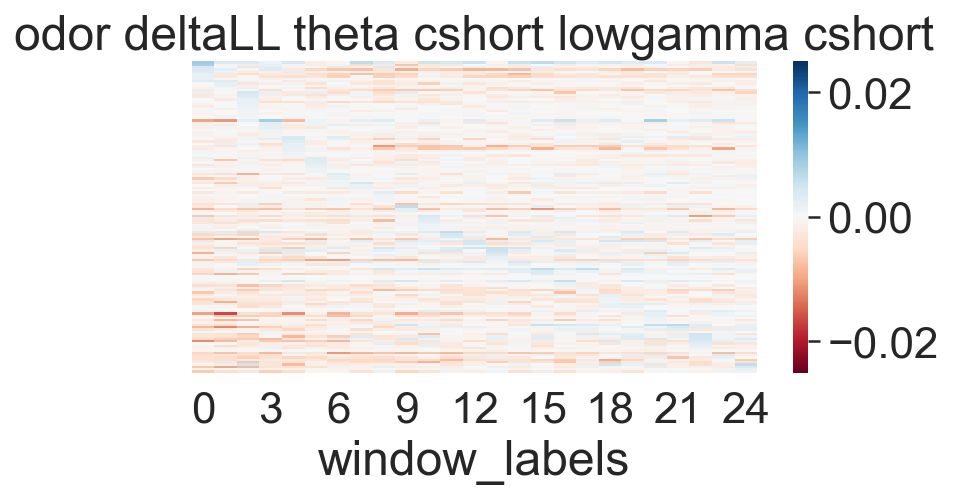

In [50]:
cmin = -0.025
# sns.heatmap(odor_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))

g1 = sns.heatmap(odor_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('odor deltaLL theta cshort lowgamma cshort')
# g1.set_xlabel('')

plt.tight_layout()
# plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_odor_thetacshort_min_lowgammacshort.pdf')


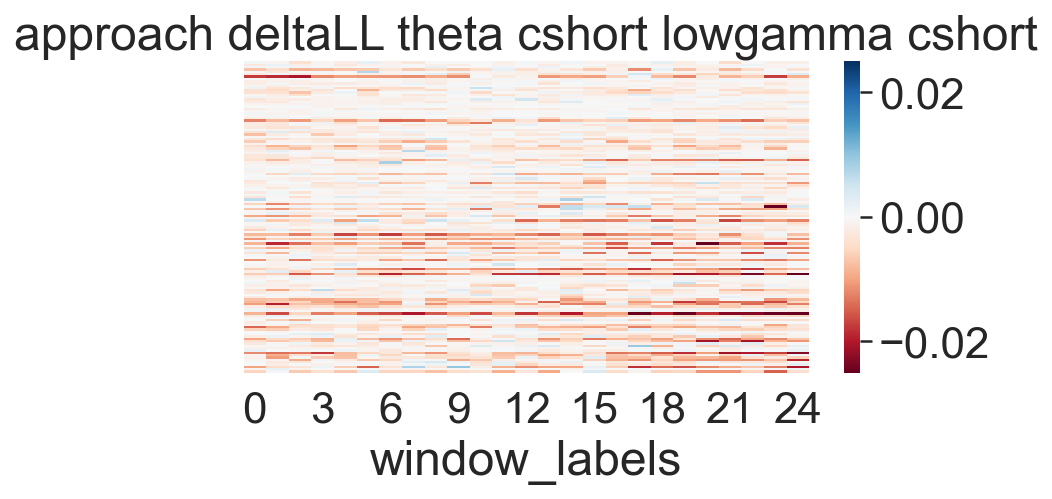

In [44]:
g1 = sns.heatmap(approach_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('approach deltaLL theta cshort lowgamma cshort')
# g1.set_xlabel('')

plt.tight_layout()
# plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_approach_thetacshort_min_lowgammacshort.pdf')


In [47]:
odor_premap = ordered_df_odor.groupby(['ordering','window_labels']).median()['delta_logloss_theta_minus_hshort'].reset_index()
odor_map = odor_premap.pivot("ordering","window_labels",'delta_logloss_theta_minus_hshort')

approach_premap = ordered_df_approach.groupby(['ordering','window_labels']).median()['delta_logloss_theta_minus_hshort'].reset_index()
approach_map = approach_premap.pivot("ordering","window_labels",'delta_logloss_theta_minus_hshort')


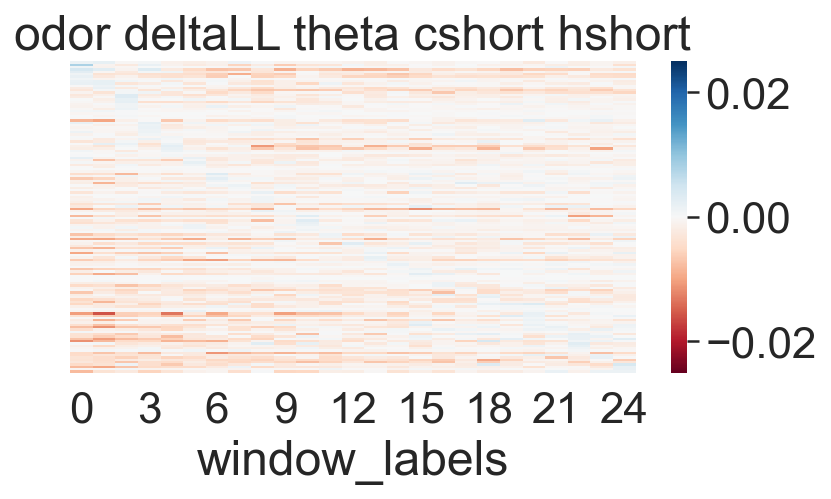

In [48]:
g1 = sns.heatmap(odor_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('odor deltaLL theta cshort hshort')
# g1.set_xlabel('')

plt.tight_layout()
# plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_odor_thetacshort_min_hshort.pdf')


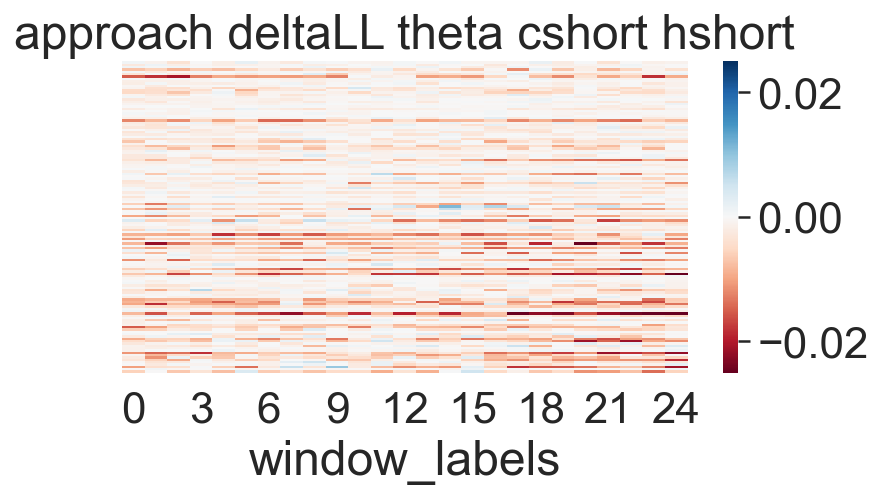

In [24]:
g1 = sns.heatmap(approach_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('approach deltaLL theta cshort hshort')
# g1.set_xlabel('')

plt.tight_layout()
# plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_approach_thetacshort_min_hshort.pdf')


In [25]:
odor_premap = ordered_df_odor.groupby(['ordering','window_labels']).median()['delta_logloss_lowgamma_minus_hshort'].reset_index()
odor_map = odor_premap.pivot("ordering","window_labels",'delta_logloss_lowgamma_minus_hshort')

approach_premap = ordered_df_approach.groupby(['ordering','window_labels']).median()['delta_logloss_lowgamma_minus_hshort'].reset_index()
approach_map = approach_premap.pivot("ordering","window_labels",'delta_logloss_lowgamma_minus_hshort')


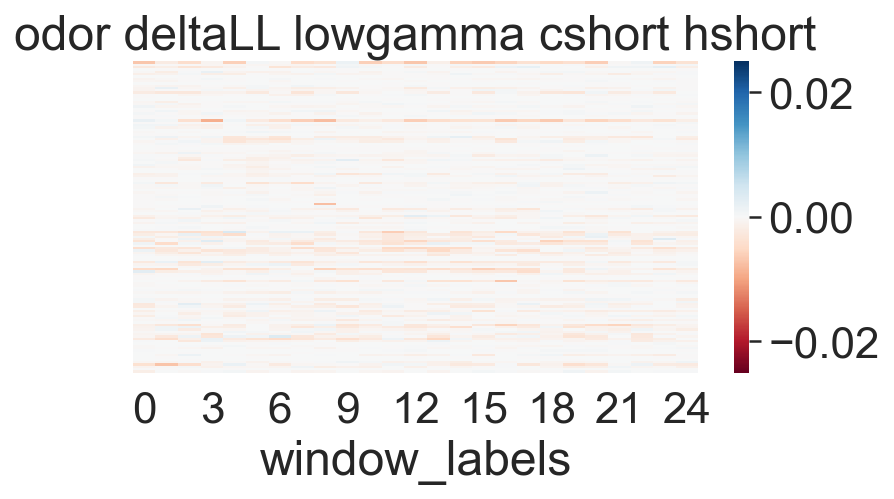

In [26]:
g1 = sns.heatmap(odor_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('odor deltaLL lowgamma cshort hshort')
# g1.set_xlabel('')

plt.tight_layout()
# plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_odor_lowgammacshort_min_hshort.pdf')



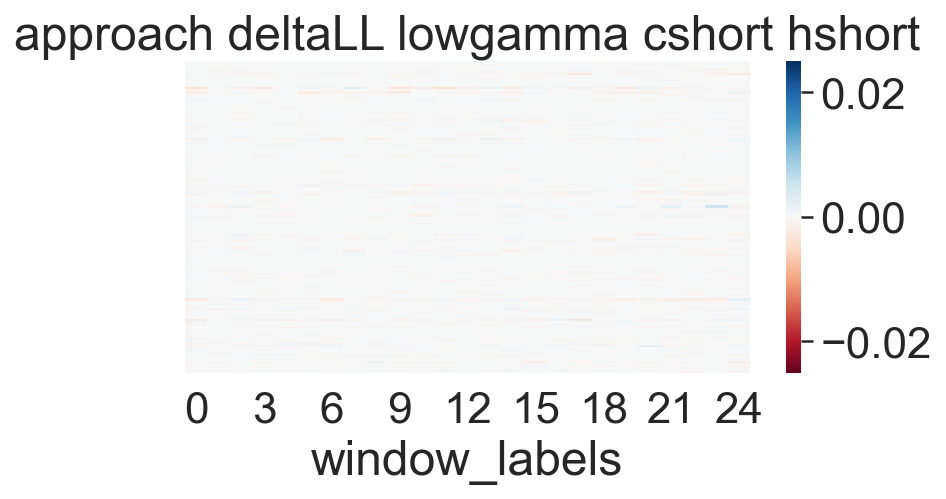

In [27]:
g1 = sns.heatmap(approach_map,cmap="RdBu",center=0, vmin = cmin, vmax = np.abs(cmin))
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('approach deltaLL lowgamma cshort hshort')
# g1.set_xlabel('')

plt.tight_layout()
# plt.savefig('RESULTS/figures/JNeurophysiol_subplot_deltaLLovertime_orderedBy_odorLLDeltaTcshortLcshort_allcells_approach_lowgammacshort_min_hshort.pdf')


# statistics
Compare the median log loss delta per cell per window against a distribution of log loss deltas generated from shuffled log losses. This won't require re-fitting the models, it'll just require shuffling log losses for a given model in time, then computing the log loss delta relative to the comparison model. 

### one-sample t-test to test the hypothesis that a given window's log loss is significantly different from a distribution centered at 0

with Bonferoni corrected $alpha = 0.001 / n windows$

In [145]:
cell_path = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/thetaphase_250ms/folds/0/single_neuron/'
cell_labels = os.listdir(cell_path)
cell_labels = [c for c in cell_labels if not c.startswith('.')]
datapath = 'RESULTS/PHASE_HIST_MODELS_all_realcells/intlogoddsCompleteSinglePredMdls940/'

rh_folders = os.listdir(datapath)

window_size = 50
window_slide = 50
model_subset = ['cshort','hshort']
rhythm_subset = ['theta','lowgamma'] # uncomment for odor dfs
# rhythm_subset = ['theta_250ms','lowgamma_250ms'] #uncomment for approach dfs

loss_delta_tmp = []

gather_dfs = []

for cell_id in tqdm(cell_labels):
    
    for fold in range(20): 


        ptest, test = grab_probs_and_data(datapath,rh_folders,cell_id,fold,'probs_models_test.csv','test_data.csv')

        ll_ptest = compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset)

        #take the mean here because: the model probabilities are so close to zero, and spiking is so rare, that most 
        #of the time the losses will be really really small, and only rarely will they be close to ~4 or ~5. Taking 
        #the mean of this very skewed (bimodal) distribution ensures that you're taking the large losses into account
        #and will thus be able to distinguish between subtle differences in model performance.
        grouped_ptest = ll_ptest.groupby(['rhythm','trial_labels','window_labels']).mean()[['logloss_cshort','logloss_hshort']].reset_index()
        grouped_ptest = ll_ptest.groupby(['rhythm','window_labels']).mean()[['logloss_cshort','logloss_hshort']].reset_index()

        grouped_ptest['fold'] = np.repeat(fold,grouped_ptest.shape[0])
        grouped_ptest['cell_id'] = np.repeat(cell_id,grouped_ptest.shape[0])
        
        gather_dfs.append(grouped_ptest)

    
odor_losses_df = pd.concat(gather_dfs)
    

  0%|                                                   | 0/134 [00:00<?, ?it/s]/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_744/487413070.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['spikes'] = subtest['spikes']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_744/487413070.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['phases'] = subtest['phase']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_744/487413070.py:76: SettingWithCopyWarning:

In [146]:
odor_losses_df.to_csv('odor_losses_df_windowed50ms.csv')

In [7]:
cell_path = 'RESULTS/PHASE_HIST_MODELS_highvapproach_correctedPos_all_realcells/starintlogoddsCompleteSinglePredMdls/theta_250ms/folds/0/'
cell_labels = os.listdir(cell_path)
cell_labels = [c for c in cell_labels if not c.startswith('.')]
datapath = 'RESULTS/PHASE_HIST_MODELS_highvapproach_correctedPos_all_realcells/starintlogoddsCompleteSinglePredMdls/'

rh_folders = os.listdir(datapath)

window_size = 50
window_slide = 50
model_subset = ['cshort','hshort']
# rhythm_subset = ['theta','lowgamma'] # uncomment for odor dfs
rhythm_subset = ['theta_250ms','lowgamma_250ms'] #uncomment for approach dfs

loss_delta_tmp = []

gather_dfs = []

for cell_id in tqdm(cell_labels):
    
    for fold in range(20): 


        ptest, test = grab_probs_and_data(datapath,rh_folders,cell_id,fold,'probs_models_test.csv','test_data.csv')

        ll_ptest = compute_logloss_deltas(ptest, test, window_size, window_slide, model_subset, rhythm_subset)

        #take the mean here because: the model probabilities are so close to zero, and spiking is so rare, that most 
        #of the time the losses will be really really small, and only rarely will they be close to ~4 or ~5. Taking 
        #the mean of this very skewed (bimodal) distribution ensures that you're taking the large losses into account
        #and will thus be able to distinguish between subtle differences in model performance.
        grouped_ptest = ll_ptest.groupby(['rhythm','trial_labels','window_labels']).mean()[['logloss_cshort','logloss_hshort']].reset_index()
        grouped_ptest = ll_ptest.groupby(['rhythm','window_labels']).mean()[['logloss_cshort','logloss_hshort']].reset_index()

        grouped_ptest['fold'] = np.repeat(fold,grouped_ptest.shape[0])
        grouped_ptest['cell_id'] = np.repeat(cell_id,grouped_ptest.shape[0])
        
        gather_dfs.append(grouped_ptest)

    
approach_losses_df = pd.concat(gather_dfs)
    

  0%|                                                   | 0/134 [00:00<?, ?it/s]/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_744/487413070.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['spikes'] = subtest['spikes']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_744/487413070.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subptest['phases'] = subtest['phase']
/var/folders/77/x73vjx_n4hbdrlkp_6ry45mr0000gn/T/ipykernel_744/487413070.py:76: SettingWithCopyWarning:

In [10]:
approach_losses_df.to_csv('approach_losses_windowed50ms.csv')

In [11]:
approach_losses_df

,rhythm,window_labels,logloss_cshort,logloss_hshort,fold,cell_id
0,lowgamma_250ms,0,0.172266,0.172638,0,LH2_D11_ctxtsig_odorblock1_TETSPK05a.mat
1,lowgamma_250ms,1,0.170137,0.170092,0,LH2_D11_ctxtsig_odorblock1_TETSPK05a.mat
2,lowgamma_250ms,2,0.156375,0.155900,0,LH2_D11_ctxtsig_odorblock1_TETSPK05a.mat
3,lowgamma_250ms,3,0.215386,0.215269,0,LH2_D11_ctxtsig_odorblock1_TETSPK05a.mat
4,lowgamma_250ms,4,0.157749,0.157544,0,LH2_D11_ctxtsig_odorblock1_TETSPK05a.mat
...,...,...,...,...,...,...
45,theta_250ms,20,0.239734,0.241330,19,LH16_D23_ctxtsig_odorblock1_TETSPK09c.mat
46,theta_250ms,21,0.256671,0.265646,19,LH16_D23_ctxtsig_odorblock1_TETSPK09c.mat
47,theta_250ms,22,0.222716,0.227098,19,LH16_D23_ctxtsig_odorblock1_TETSPK09c.mat
48,theta_250ms,23,0.244489,0.239441,19,LH16_D23_ctxtsig_odorblock1_TETSPK09c.mat


In [35]:
approach_losses_df['deltas'] = approach_losses_df['logloss_cshort'] - approach_losses_df['logloss_hshort']

In [36]:
#134 neurons, 20 folds, 2 rhythms, 25 time windows
134*20*2*25

134000

In [30]:
#try a t-test
import scipy.stats as stats



In [118]:
cell_labels = list(set(ordered_df_odor['cell_id'].tolist())) 
window_labels = list(set(ordered_df_odor['window_labels'].tolist()))
model_comparison = ['delta_logloss_theta_minus_lowgamma','delta_logloss_theta_minus_hshort','delta_logloss_lowgamma_minus_hshort']

delta_results = [] 
for cell_id in tqdm(cell_labels):
    
    subcell = ordered_df_odor[ordered_df_odor['cell_id'] == cell_id]
    
    for mc in model_comparison:
        
        subcellmodel = subcell[[mc,'window_labels','fold','core_cell_id','ordering']]
    
        for window in window_labels: 
            
            subcellmodelwin = subcellmodel[subcellmodel['window_labels'] == window]
            
            deltas_dist = subcellmodelwin[mc].values
            
            t = stats.ttest_1samp(a=deltas_dist,popmean=0,alternative='two-sided')
            
            tstat = t[0]
            pval = t[1]
            
            ordering = subcellmodelwin['ordering'].iloc[0]
            
            delta_results.append({'cell_id': cell_id,
                                  'ordering': ordering,
                                  'window_labels': window,
                                  'model_comparison': mc,
                                  'tstat': tstat,
                                  'pval': pval,
                                  'alpha': 0.001
                                 })
            
results_odor_df = pd.DataFrame(delta_results)



                
            

100%|█████████████████████████████████████████| 134/134 [00:07<00:00, 18.24it/s]


In [119]:
significance = []
for cell_id in cell_labels: 
    
    subcell = results_odor_df[results_odor_df['cell_id'] == cell_id]
    
    for mc in model_comparison:
        
        subcellmodel = subcell[subcell['model_comparison'] == mc]
    
        for window in window_labels: 

            subcellwin = subcellmodel[subcellmodel['window_labels'] == window]

            if subcellwin['pval'].values < 0.001/len(window_labels): 

                if subcellwin['tstat'].values < 0: 

                    significance.append(np.repeat(-1, subcellwin.shape[0]))
                    
                elif subcellwin['tstat'].values > 0:
                    
                    significance.append(np.repeat(1, subcellwin.shape[0]))

            else: 

                significance.append(np.repeat(0, subcellwin.shape[0]))
            
results_odor_df['significant'] = np.concatenate(significance).ravel()

In [120]:
results_odor_df

,cell_id,ordering,window_labels,model_comparison,tstat,pval,alpha,significant
0,LH16_08_11_14_D23_theta_correct_odorblock1TETSPK09c,75,0,delta_logloss_theta_minus_lowgamma,-13.306201,4.439777e-11,0.001,-1
1,LH16_08_11_14_D23_theta_correct_odorblock1TETSPK09c,75,1,delta_logloss_theta_minus_lowgamma,-9.071611,2.468343e-08,0.001,-1
2,LH16_08_11_14_D23_theta_correct_odorblock1TETSPK09c,75,2,delta_logloss_theta_minus_lowgamma,-12.224405,1.893530e-10,0.001,-1
3,LH16_08_11_14_D23_theta_correct_odorblock1TETSPK09c,75,3,delta_logloss_theta_minus_lowgamma,-2.849294,1.025809e-02,0.001,0
4,LH16_08_11_14_D23_theta_correct_odorblock1TETSPK09c,75,4,delta_logloss_theta_minus_lowgamma,-2.236877,3.747902e-02,0.001,0
...,...,...,...,...,...,...,...,...
10045,LH2_11_27_12_D14_theta_correct_odorblock1TETSPK41d,63,20,delta_logloss_lowgamma_minus_hshort,-2.239396,3.728790e-02,0.001,0
10046,LH2_11_27_12_D14_theta_correct_odorblock1TETSPK41d,63,21,delta_logloss_lowgamma_minus_hshort,-1.120056,2.766493e-01,0.001,0
10047,LH2_11_27_12_D14_theta_correct_odorblock1TETSPK41d,63,22,delta_logloss_lowgamma_minus_hshort,4.085034,6.309442e-04,0.001,0
10048,LH2_11_27_12_D14_theta_correct_odorblock1TETSPK41d,63,23,delta_logloss_lowgamma_minus_hshort,2.885807,9.469288e-03,0.001,0


<AxesSubplot:xlabel='window_labels', ylabel='ordering'>

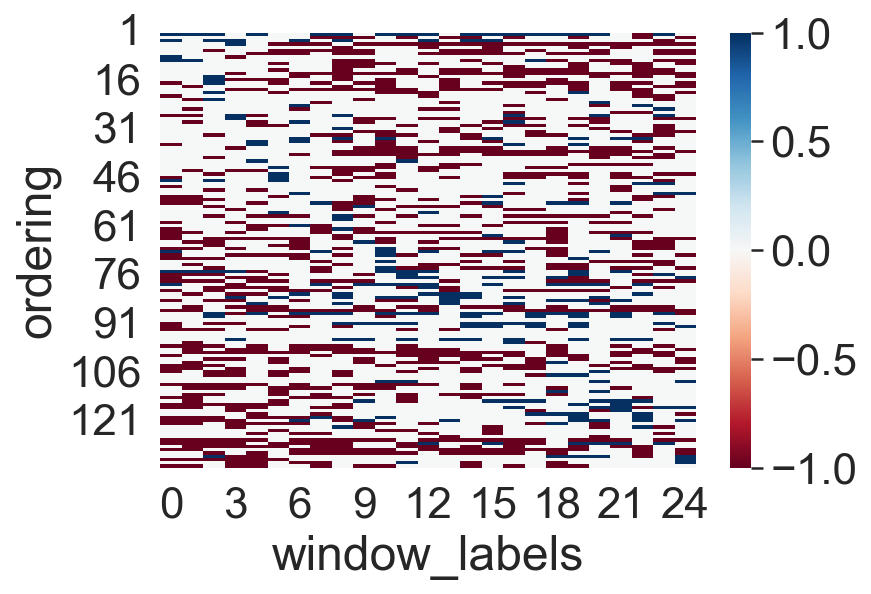

In [121]:
odor_sigmap_thetaphaseSH_lowgammaphaseSH = results_odor_df[results_odor_df['model_comparison'] == 'delta_logloss_theta_minus_lowgamma']
heatmap_thetaphaseSH_lowgammaphaseSH = odor_sigmap_thetaphaseSH_lowgammaphaseSH.pivot("ordering","window_labels","significant")
sns.heatmap(data=heatmap_thetaphaseSH_lowgammaphaseSH,cmap='RdBu',center=0)


<AxesSubplot:xlabel='window_labels', ylabel='ordering'>

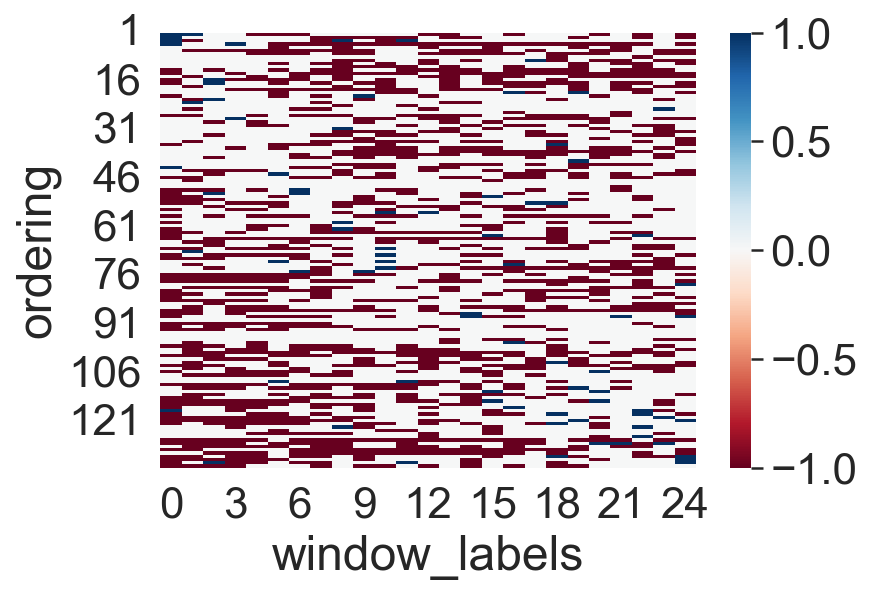

In [122]:
odor_sigmap_thetaphaseSH_SH = results_odor_df[results_odor_df['model_comparison'] == 'delta_logloss_theta_minus_hshort']
heatmap_thetaphaseSH_lowgammaphaseSH = odor_sigmap_thetaphaseSH_SH.pivot("ordering","window_labels","significant")
sns.heatmap(data=heatmap_thetaphaseSH_lowgammaphaseSH, cmap='RdBu', center=0)


<AxesSubplot:xlabel='window_labels', ylabel='ordering'>

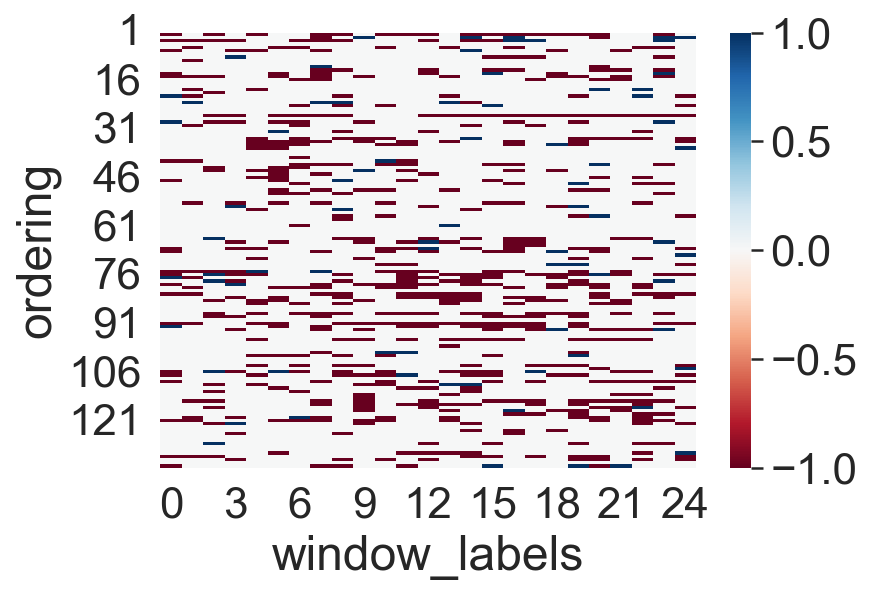

In [123]:
odor_sigmap_lowgammaphaseSH_SH = results_odor_df[results_odor_df['model_comparison'] == 'delta_logloss_lowgamma_minus_hshort']
heatmap_lowgammaphaseSH_SH = odor_sigmap_lowgammaphaseSH_SH.pivot("ordering","window_labels","significant")
sns.heatmap(data=heatmap_lowgammaphaseSH_SH,cmap = 'RdBu',center=0)


In [60]:
cell_labels = list(set(ordered_df_approach['cell_id'].tolist())) 
window_labels = list(set(ordered_df_approach['window_labels'].tolist()))
model_comparison = ['delta_logloss_theta_minus_lowgamma','delta_logloss_theta_minus_hshort','delta_logloss_lowgamma_minus_hshort']

delta_results = [] 
for cell_id in tqdm(cell_labels):
    
    subcell = ordered_df_approach[ordered_df_approach['cell_id'] == cell_id]
    
    for mc in model_comparison:
        
        subcellmodel = subcell[[mc,'window_labels','fold','core_cell_id','ordering']]
    
        for window in window_labels: 
            
            subcellmodelwin = subcellmodel[subcellmodel['window_labels'] == window]
            
            deltas_dist = subcellmodelwin[mc].values
            
            t = stats.ttest_1samp(a=deltas_dist,popmean=0,alternative='two-sided')
            
            tstat = t[0]
            pval = t[1]
            
            ordering = subcellmodelwin['ordering'].iloc[0]
            
            delta_results.append({'cell_id': cell_id,
                                  'ordering': ordering,
                                  'window_labels': window,
                                  'model_comparison': mc,
                                  'tstat': tstat,
                                  'pval': pval,
                                  'alpha': 0.001
                                 })
            
results_approach_df = pd.DataFrame(delta_results)

100%|█████████████████████████████████████████| 134/134 [00:07<00:00, 18.17it/s]


In [109]:
significance = []
for cell_id in cell_labels: 
    
    subcell = results_approach_df[results_approach_df['cell_id'] == cell_id]
    
    for mc in model_comparison:
        
        subcellmodel = subcell[subcell['model_comparison'] == mc]
    
        for window in window_labels: 

            subcellwin = subcellmodel[subcellmodel['window_labels'] == window]

            if subcellwin['pval'].values < 0.001/len(window_labels): 
                
                if subcellwin['tstat'].values < 0: 

                    significance.append(np.repeat(-1, subcellwin.shape[0]))
                    
                elif subcellwin['tstat'].values > 0:
                    
                    significance.append(np.repeat(1, subcellwin.shape[0]))

            else: 

                significance.append(np.repeat(0, subcellwin.shape[0]))
            
results_approach_df['significant'] = np.concatenate(significance).ravel()

<AxesSubplot:xlabel='window_labels', ylabel='ordering'>

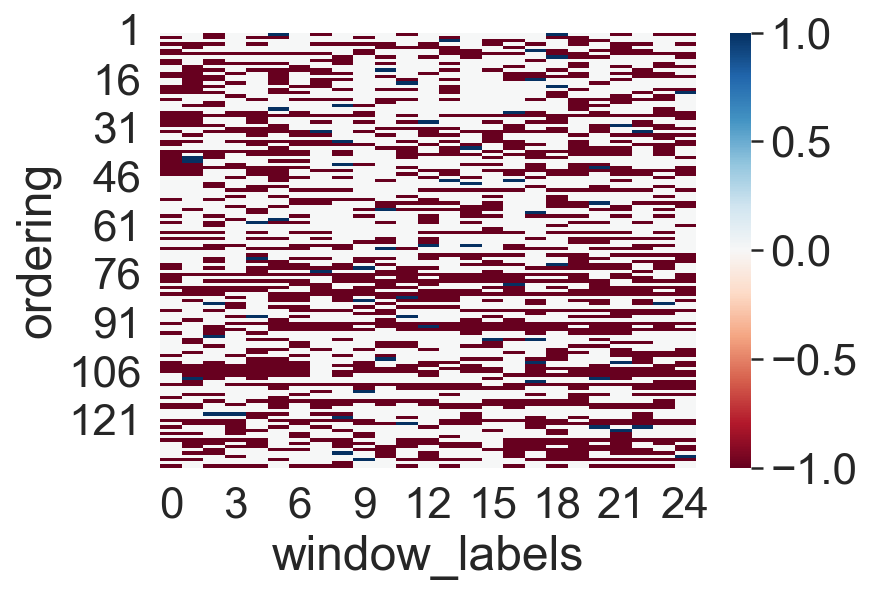

In [112]:
approach_sigmap_thetaphaseSH_lowgammaphaseSH = results_approach_df[results_approach_df['model_comparison'] == 'delta_logloss_theta_minus_lowgamma']
heatmap_thetaphaseSH_lowgammaphaseSH = approach_sigmap_thetaphaseSH_lowgammaphaseSH.pivot("ordering","window_labels","significant")
sns.heatmap(data=heatmap_thetaphaseSH_lowgammaphaseSH,cmap = 'RdBu',center=0)


<AxesSubplot:xlabel='window_labels', ylabel='ordering'>

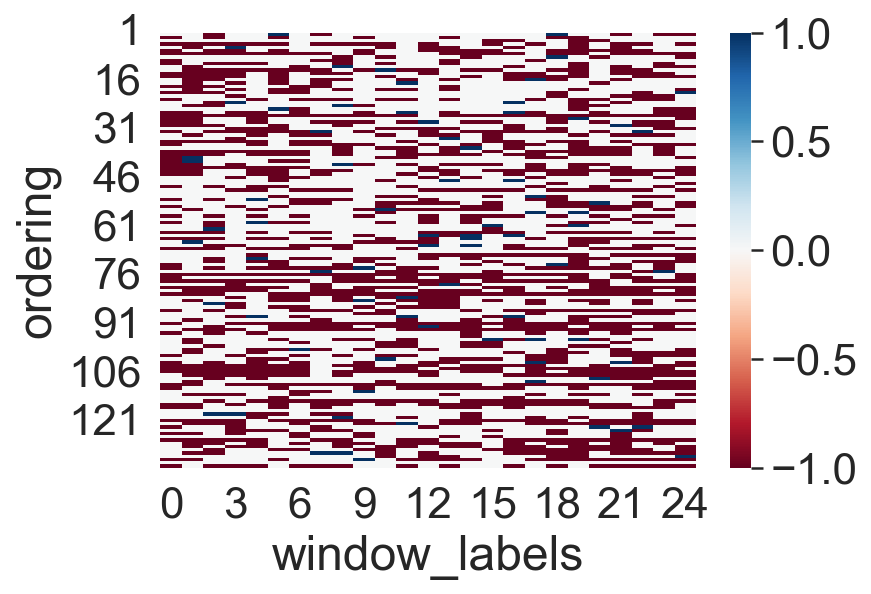

In [114]:
approach_sigmap_thetaphaseSH_SH = results_approach_df[results_approach_df['model_comparison'] == 'delta_logloss_theta_minus_hshort']
heatmap_thetaphaseSH_lowgammaphaseSH = approach_sigmap_thetaphaseSH_SH.pivot("ordering","window_labels","significant")
sns.heatmap(data=heatmap_thetaphaseSH_lowgammaphaseSH, cmap='RdBu',center=0)

<AxesSubplot:xlabel='window_labels', ylabel='ordering'>

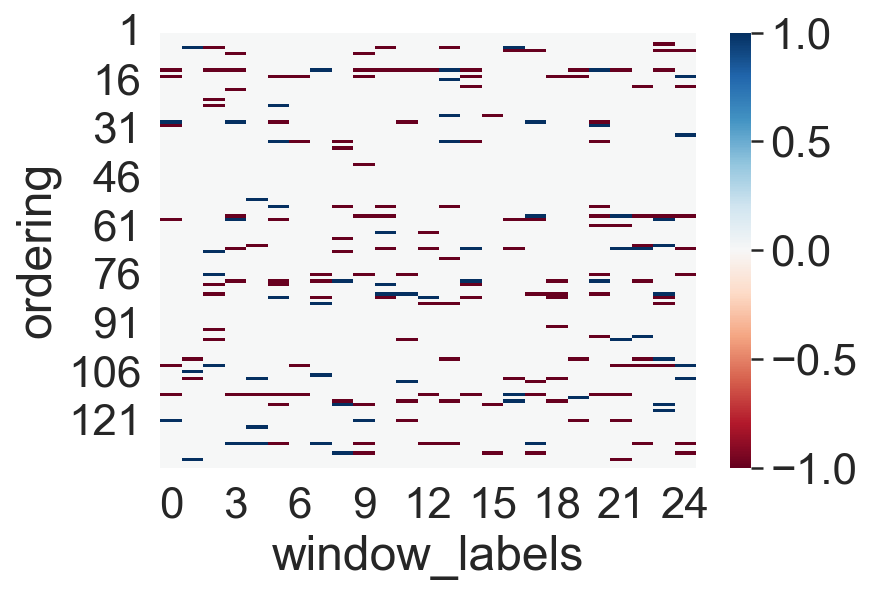

In [115]:
approach_sigmap_lowgammaphaseSH_SH = results_approach_df[results_approach_df['model_comparison'] == 'delta_logloss_lowgamma_minus_hshort']
heatmap_lowgammaphaseSH_SH = approach_sigmap_lowgammaphaseSH_SH.pivot("ordering","window_labels","significant")
sns.heatmap(data=heatmap_lowgammaphaseSH_SH,cmap = 'RdBu',center=0)


## subplots

In [124]:
cells_odor = ['LH16_08_22_14_D29_theta_correct_odorblock2TETSPK53c',
              'LH9_10_10_13_D10_theta_correct_odorblock2TETSPK13a',
              'LH16_08_08_14_D22_theta_correct_odorblock2TETSPK09a']

cells_app = ['LH16_D29_ctxtsig_odorblock2_TETSPK53c.mat',
              'LH9_D10_ctxtsig_odorblock2_TETSPK13a.mat',
              'LH16_D22_ctxtsig_odorblock2_TETSPK09a.mat']

In [125]:
df_app_subset = results_approach_df[results_approach_df['cell_id'].isin(cells_app)]
df_odor_subset = results_odor_df[results_odor_df['cell_id'].isin(cells_odor)]


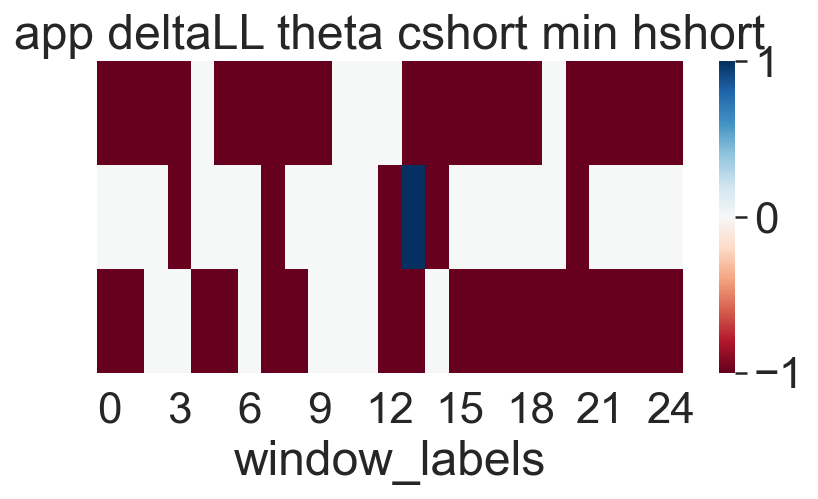

In [126]:
tmp = df_app_subset.reset_index()
tmp = tmp[tmp['model_comparison'] == 'delta_logloss_theta_minus_hshort']
# tmp2 = tmp.groupby(['cell_id','window_labels']).median()['significant'].reset_index()
tmp3 = tmp.pivot("cell_id","window_labels","significant")

g1 = sns.heatmap(tmp3, cmap='RdBu',center=0)
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('app deltaLL theta cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()

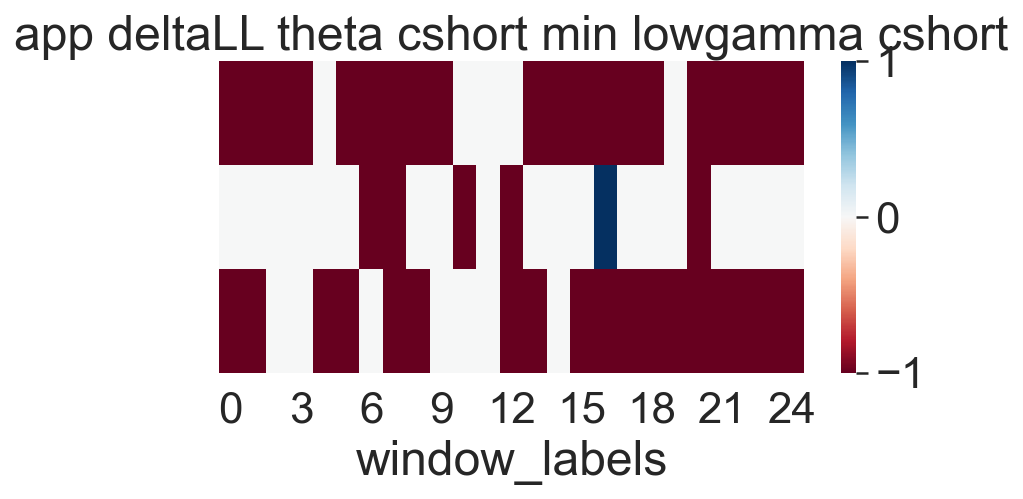

In [127]:
tmp = df_app_subset.reset_index()
tmp = tmp[tmp['model_comparison'] == 'delta_logloss_theta_minus_lowgamma']
# tmp2 = tmp.groupby(['cell_id','window_labels']).median()['significant'].reset_index()
tmp3 = tmp.pivot("cell_id","window_labels","significant")

g1 = sns.heatmap(tmp3,cmap='RdBu',center=0)
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('app deltaLL theta cshort min lowgamma cshort')
# g1.set_xlabel('')

plt.tight_layout()

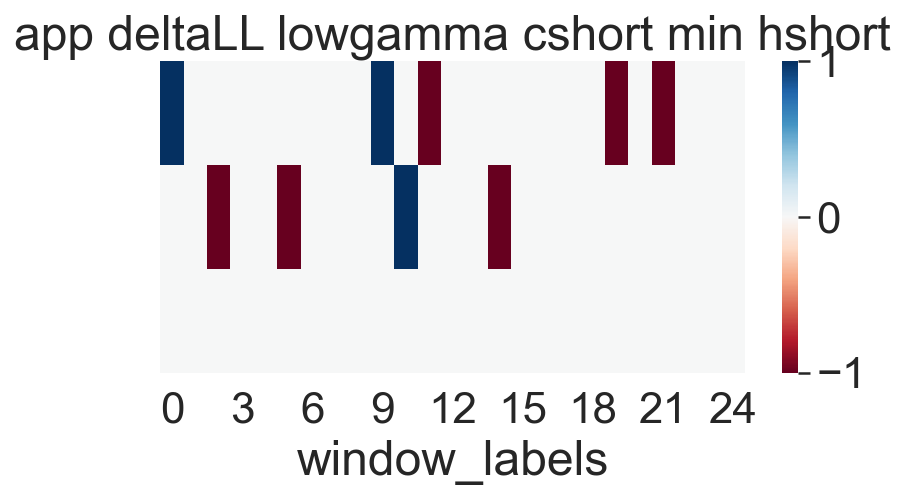

In [128]:
tmp = df_app_subset.reset_index()
tmp = tmp[tmp['model_comparison'] == 'delta_logloss_lowgamma_minus_hshort']
# tmp2 = tmp.groupby(['cell_id','window_labels']).median()['significant'].reset_index()
tmp3 = tmp.pivot("cell_id","window_labels","significant")

g1 = sns.heatmap(tmp3,cmap='RdBu',center=0)
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('app deltaLL lowgamma cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()

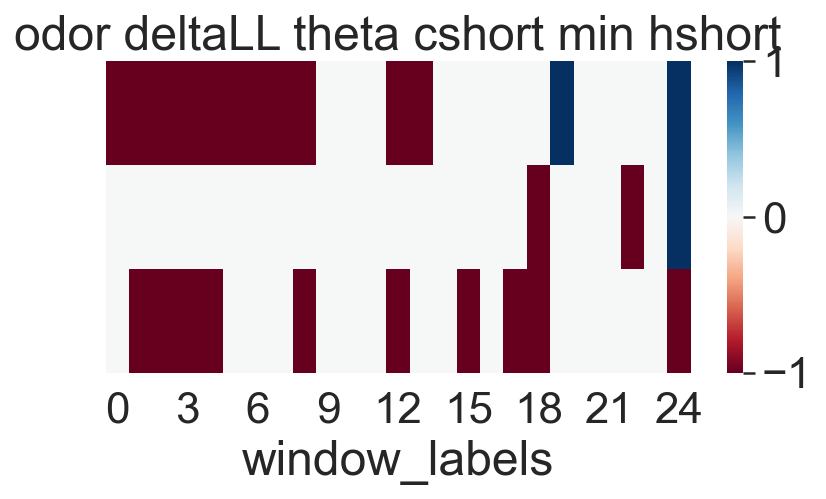

In [129]:
tmp = df_odor_subset.reset_index()
tmp = tmp[tmp['model_comparison'] == 'delta_logloss_theta_minus_hshort']
# tmp2 = tmp.groupby(['cell_id','window_labels']).median()['significant'].reset_index()
tmp3 = tmp.pivot("cell_id","window_labels","significant")

g1 = sns.heatmap(tmp3,cmap='RdBu',center=0)
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('odor deltaLL theta cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()

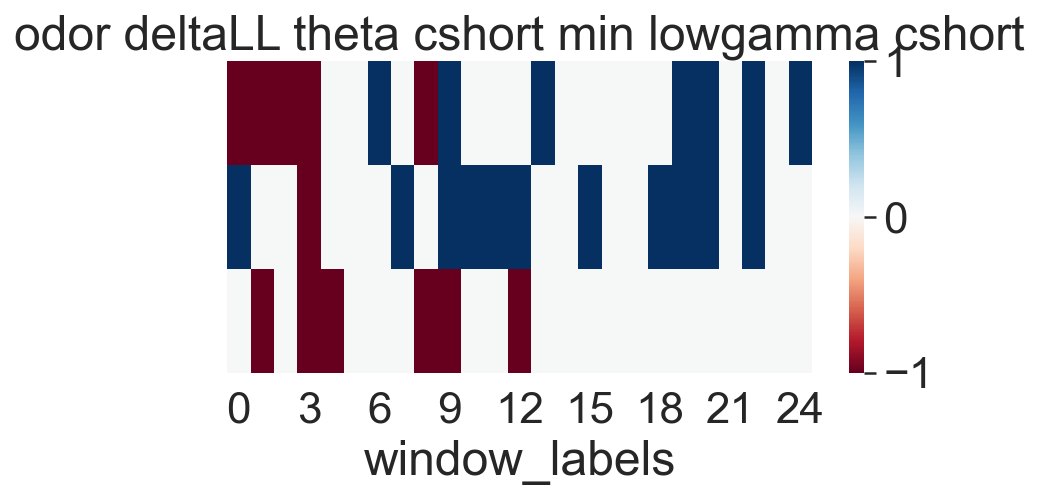

In [130]:
tmp = df_odor_subset.reset_index()
tmp = tmp[tmp['model_comparison'] == 'delta_logloss_theta_minus_lowgamma']
# tmp2 = tmp.groupby(['cell_id','window_labels']).median()['significant'].reset_index()
tmp3 = tmp.pivot("cell_id","window_labels","significant")

g1 = sns.heatmap(tmp3,cmap='RdBu',center=0)
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('odor deltaLL theta cshort min lowgamma cshort')
# g1.set_xlabel('')

plt.tight_layout()

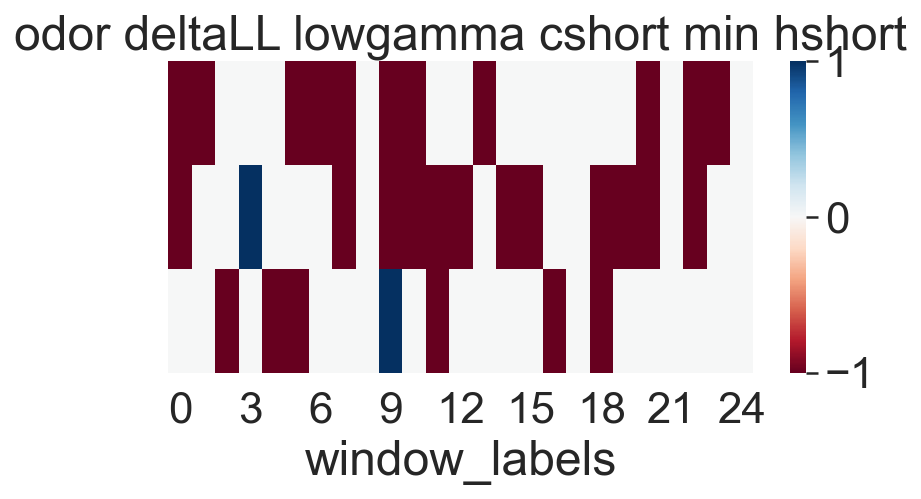

In [131]:
tmp = df_odor_subset.reset_index()
tmp = tmp[tmp['model_comparison'] == 'delta_logloss_lowgamma_minus_hshort']
# tmp2 = tmp.groupby(['cell_id','window_labels']).median()['significant'].reset_index()
tmp3 = tmp.pivot("cell_id","window_labels","significant")

g1 = sns.heatmap(tmp3,cmap='RdBu',center=0)
g1.set_ylabel('')
g1.set_yticklabels('')
g1.set_title('odor deltaLL lowgamma cshort min hshort')
# g1.set_xlabel('')

plt.tight_layout()

In [75]:
# cell_labels = list(set(approach_losses_df['cell_id'].tolist())) 
# window_labels = list(set(approach_losses_df['window_labels'].tolist()))
# rh_subset = ['theta_250ms','lowgamma_250ms']

# delta_results = [] 
# for cell_id in tqdm(cell_labels):
    
#     subcell = approach_losses_df[approach_losses_df['cell_id'] == cell_id]
    
#     for rhythm in rh_subset: 
        
#         subcellrh = subcell[subcell['rhythm'] == rhythm]
        
#         for window in window_labels: 
            
#             subcellrhwin = subcellrh[subcellrh['window_labels'] == window]
            
#             deltas_dist = subcellrhwin['deltas'].values
        
#             t = stats.ttest_1samp(a=deltas_dist,popmean=0,alternative='two-sided')
            
#             tstat = t[0]
#             pval = t[1]
            
#             delta_results.append({'cell_id': cell_id,
#                                   'window_labels': window,
#                                   'model_comparison': rhythm + 'phaseSH_SH',
#                                   'tstat': tstat,
#                                   'pval': pval,
#                                   'alpha': 0.001
#                                  })
            
# results_df = pd.DataFrame(delta_results)
        

In [43]:
# results_df = approach_losses_df.join(results_df.set_index('cell_id'), on='cell_id',rsuffix='_ttest_results')

In [76]:
# len(results_df[results_df['pval']<.002])/len(results_df)

In [77]:
# subrh = results_df[results_df['model_comparison'] == 'theta_250msphaseSH_SH']

# cell_index = []
# for index,cell_id in enumerate(cell_labels): 
    
#     subrhcell = subrh[subrh['cell_id'] == cell_id]
    
#     cell_index.append(np.repeat(index,subrhcell.shape[0])) 
    

# flat_cell_index = np.concatenate(cell_index).ravel()

# subrh['cell_index'] = flat_cell_index

# significance = []
# for cell_id in cell_labels: 
    
#     subrhcell = subrh[subrh['cell_id'] == cell_id]
    
#     for window in window_labels: 
        
#         subrhcellwin = subrhcell[subrhcell['window_labels'] == window]
        
#         if subrhcellwin['pval'].values < 0.001/len(window_labels): 
            
#             significance.append(np.repeat(1, subrhcellwin.shape[0]))
            
#         else: 
            
#             significance.append(np.repeat(0, subrhcellwin.shape[0]))
            
# subrh['significant'] = np.concatenate(significance).ravel()
    




In [132]:
# heatmap = subrh.pivot("cell_index","window_labels","significant")

In [78]:
# sns.heatmap(data=heatmap)

In [65]:
# cell_labels = list(set(approach_losses_df['cell_id'].tolist())) 
# window_labels = list(set(approach_losses_df['window_labels'].tolist()))
# rh_subset = ['theta_250ms']#,'lowgamma_250ms']

# gather_dfs = [] 
# for cell_id in tqdm(cell_labels):
    
#     subcell = approach_losses_df[approach_losses_df['cell_id'] == cell_id]
    
#     for rhythm in rh_subset: 
        
#         subcellrh = subcell[subcell['rhythm'] == rhythm]
            
#         for perm in range(10):

#             for fold in range(20): 
                
#                 subcellrhfold = subcellrh[subcellrh['fold'] == fold]
                
#                 #shuffle the rows independently for each model--results in large deltas 
# #                 subcellrhfold['shuffled_losses_cshort'] = np.random.permutation(subcellrhfold['logloss_cshort'].values)
# #                 subcellrhfold['shuffled_losses_hshort'] = np.random.permutation(subcellrhfold['logloss_hshort'].values)
        
#                 #shuffle the rows together for both models
#                 subcellrhfold['shuffled_window_labels'] = np.random.permutation(subcellrhfold['window_labels'].values)
                
#                 subcellrhfold['cell_id'] = np.repeat(cell_id,subcellrhfold.shape[0])
#                 subcellrhfold['rhythm'] = np.repeat(rhythm,subcellrhfold.shape[0])
#                 subcellrhfold['permutation'] = np.repeat(perm,subcellrhfold.shape[0])
                
                
#                 gather_dfs.append(subcellrhfold)
                
# perms_df = pd.concat(gather_dfs)              
                

In [66]:
# perms_df['delta'] = perms_df['logloss_cshort'].values - perms_df['logloss_hshort'].values
# perms_df.head(5)

In [67]:
# df_baseline = perms_df.groupby(['shuffled_window_labels', 'permutation'], 
#                  as_index=False).median()[['shuffled_window_labels', 'permutation', 'delta']]

# df_baseline.head(5)

In [68]:
# df_windows = perms_df.groupby('window_labels', as_index=False).median()[['window_labels', 'delta']]
# df_windows.head(5)

In [69]:
# sns.lineplot(data = df_baseline,
#             x = 'shuffled_window_labels',
#             y = 'delta')

# sns.lineplot(data = df_windows,
#             x = 'window_labels',
#             y = 'delta')

In [70]:
# subcell = perms_df[perms_df['cell_id']=='LH9_D21_ctxtsig_odorblock2_TETSPK13a.mat']
# subcellrh = subcell[subcell['rhythm'] == 'theta_250ms']
# window_labels = list(set(subcellrh['window_labels'].tolist()))
# fig,ax = plt.subplots(len(window_labels),1,figsize=(15,40))

# for window in window_labels: 
    
#     subwinperm = subcellrh[subcellrh['shuffled_window_labels']==window]
#     subwinorig = subcellrh[subcellrh['window_labels']==window]

   
        
#     ax[window].hist(subwinperm['delta'].values,alpha=.7)
#     ax[window].vlines(x=subwinorig['delta'].median(),ymin=0,ymax=60,linewidth=4,color='k')
#     ax[window].set_ylabel('win '+ str(window))
    
#     #compute a t-test per window to as
        
# fig.tight_layout()  
# plt.xlabel('log loss delta (theta phaseSH - SH)')
# # fig.savefig('tmp_loglossdelta_over_time_bootstrap.pdf')